# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Imports</p>

In [1]:
import re
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torch.utils.data import DataLoader
from data import QADataset, Vocabulary, Tokenizer
from model import QATransformerBasedModel, TransformerEncoder, PositionalEncoding, PositionWiseFeedForward
from utils import enforce_position_constraints
from evaluate import compute_em, compute_f1
from sklearn.metrics import f1_score

c:\Users\mazen\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\mazen\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Model Evaluation</p>

In [5]:
# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 300
NUM_HEADS = 6
D_FF = 512
NUM_LAYERS = 2
DROPOUT = 0.1
MAX_CONTEXT_LEN = 400

# Device config
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Paths
MODELS_DIR = "./model/qa_transformer_based_model/"
VALIDATION_FILE = "./data/validation.json"
OUT_DIR = "./out/qa_transformer_based_model"

# Ensure directories exist
os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

Using device: cuda


In [3]:
# Prepare dataset and loader
val_dataset = QADataset(VALIDATION_FILE)

# Filter long contexts
def filter_len(df):
    return df[df['context'].map(len) <= MAX_CONTEXT_LEN].reset_index(drop=True)
    
val_dataset.samples = filter_len(val_dataset.samples)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=val_dataset._collate_batch)

In [7]:
# Iterate over checkpoints and evaluate
results = []
for fname in sorted(os.listdir(MODELS_DIR)):
    if not fname.endswith('.pt'):
        continue

    path = os.path.join(MODELS_DIR, fname)
    checkpoint = torch.load(path, map_location=device)

    # Load tokenizer and vocab
    val_vocab = checkpoint.get('vocab', fname)
    epoch = checkpoint.get('epoch', fname)
    state_dict = checkpoint.get('state_dict', fname)

    val_dataset.register_tokenizer(Tokenizer(val_vocab))

    # Initialize model and load weights
    model = QATransformerBasedModel(
        vocab=val_vocab,
        vocab_decoder=val_vocab.decoding,  # or ckpt['vocab_decoder'] if saved separately
        embedding_dim=EMBEDDING_DIM,
        num_heads=NUM_HEADS,
        d_ff=D_FF,
        num_layers=NUM_LAYERS,
        max_seq_length=MAX_CONTEXT_LEN,
        dropout_prob=DROPOUT
    ).to(device)

    model.load_state_dict(state_dict)
    model.eval()

    records = []
    em_scores, f1_scores = [], []
    start_f1_list = []
    end_f1_list = []

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            ctx      = batch["context"].to(device)
            qry      = batch["question"].to(device)
            start_gt = batch["answer_start"].to(device)
            end_gt   = batch["answer_end"].to(device)

            # forward + enforce end >= start
            s_logit, e_logit = model(ctx, qry)
            e_logit = enforce_position_constraints(e_logit, start_gt)

            s_pred = s_logit.argmax(dim=1)
            e_pred = e_logit.argmax(dim=1)
            e_pred = torch.where(e_pred < s_pred, s_pred, e_pred)

            # start/end F1 at index‐level
            start_f1_list.append(f1_score(start_gt.cpu(), s_pred.cpu(), average="macro"))
            end_f1_list.append(  f1_score(end_gt.cpu(),   e_pred.cpu(), average="macro"))

            # collect per‐sample fields
            for i in range(ctx.size(0)):
                # compute global sample idx (since shuffle=False)
                sample_idx = batch_idx * BATCH_SIZE + i
                sample     = val_dataset.samples.iloc[sample_idx]

                sp = s_pred[i].item()
                ep = e_pred[i].item()
                st = start_gt[i].item()
                et = end_gt[i].item()

                tokens     = val_dataset.tokenizer.convert_ids_to_tokens(ctx[i].cpu().tolist())
                pred_text  = " ".join(tokens[sp:ep+1]).strip()
                gold_text  = sample["answers"]["text"][0].strip()

                # span EM/F1
                em_scores.append(compute_em(pred_text, gold_text))
                f1_scores.append(compute_f1(pred_text, gold_text))

                # record 8 columns
                records.append({
                    "context":                 sample["context"],
                    "question":                sample["question"],
                    "answer":                  gold_text,
                    "predicted_answer":        pred_text,
                    "answer_start_index":      st,
                    "answer_end_index":        et,
                    "predicted_start_index":   sp,
                    "predicted_end_index":     ep,
                })

    # write per‐epoch CSV
    df_epoch = pd.DataFrame(records)
    df_epoch.to_csv(os.path.join(OUT_DIR, f"validation_output_epoch_{epoch}.csv"), index=False)
    print(f"Epoch {epoch}: saved {len(df_epoch)} rows → {os.path.join(OUT_DIR, 'eval_summary.csv')}")

    # log metrics
    results.append({
        "epoch":     epoch,
        "em":        np.mean(em_scores) * 100,
        "f1":        np.mean(f1_scores) * 100,
        "start_f1":  np.mean(start_f1_list) * 100,
        "end_f1":    np.mean(end_f1_list) * 100,
    })

Epoch 10: saved 735 rows → ./out/qa_transformer_based_model\eval_summary.csv
Epoch 15: saved 735 rows → ./out/qa_transformer_based_model\eval_summary.csv
Epoch 20: saved 735 rows → ./out/qa_transformer_based_model\eval_summary.csv
Epoch 25: saved 735 rows → ./out/qa_transformer_based_model\eval_summary.csv
Epoch 30: saved 735 rows → ./out/qa_transformer_based_model\eval_summary.csv
Epoch 5: saved 735 rows → ./out/qa_transformer_based_model\eval_summary.csv


In [8]:
# Save summary of all epochs
df_all = pd.DataFrame(results)
df_all.to_csv(os.path.join(OUT_DIR, "eval_summary.csv"), index=False)
print(f"All evaluations complete. Summary saved to {os.path.join(OUT_DIR, 'eval_summary.csv')}")

All evaluations complete. Summary saved to ./out/qa_transformer_based_model\eval_summary.csv


# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Model Loading</p>

In [9]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_dir = './model/qa_transformer_based_model/'
ckpt_file = 'QATransformerBasedModel_ep30.pt'

checkpoint = torch.load(os.path.join(checkpoint_dir, ckpt_file), map_location=device)

# Prepare validation vocab from any one checkpoint
val_vocab = checkpoint['vocab']

# Hyperparameters
BATCH_SIZE = 16
LEARNING_RATE = 1e-3
EMBEDDING_DIM = 300
NUM_HEADS = 6
D_FF = 512
NUM_LAYERS = 2
DROPOUT = 0.1
MAX_CONTEXT_LEN = 400

# Load tokenizer and vocab
val_vocab = checkpoint.get('vocab', fname)
epoch = checkpoint.get('epoch', fname)
state_dict = checkpoint.get('state_dict', fname)

val_dataset.register_tokenizer(Tokenizer(val_vocab))

# Initialize model and load weights
model = QATransformerBasedModel(
    vocab=val_vocab,
    vocab_decoder=val_vocab.decoding,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    d_ff=D_FF,
    num_layers=NUM_LAYERS,
    max_seq_length=MAX_CONTEXT_LEN,
    dropout_prob=DROPOUT
).to(device)


model.load_state_dict(state_dict)
model.eval()

QATransformerBasedModel(
  (embedding): Embedding(106348, 300, padding_idx=0)
  (pos_encoding): PositionalEncoding()
  (pre_encoders): ModuleList(
    (0): TransformerEncoder(
      (self_attn): MultiHeadAttention(
        (W_q): Linear(in_features=300, out_features=300, bias=True)
        (W_k): Linear(in_features=300, out_features=300, bias=True)
        (W_v): Linear(in_features=300, out_features=300, bias=True)
        (W_o): Linear(in_features=300, out_features=300, bias=True)
      )
      (feed_forward): PositionWiseFeedForward(
        (fc1): Linear(in_features=300, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (fc2): Linear(in_features=512, out_features=300, bias=True)
        (relu): ReLU()
      )
      (norm1): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((300,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (post_encoders): ModuleList(
    (0): Transfo

# <p style="padding:50px;background-color:#06402B;margin:0;color:#fafefe;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 15px 50px;overflow:hidden;font-weight:100">Visualization</p>

### 1. Read Validation Result

In [12]:
# Load the evaluation results from CSV
df = pd.read_csv("./out/qa_transformer_based_model/validation_output_epoch_30.csv")

# Compute extra columns if needed (for example, answer lengths)
df['gt_length'] = df['answer'].fillna('').apply(lambda x: len(x.split()))
df['pred_length'] = df['predicted_answer'].fillna('').apply(lambda x: len(x.split()))

# Compute F1 score for each row using the custom compute_f1 function
df['f1'] = df.apply(lambda row: compute_f1(row['predicted_answer'], row['answer']), axis=1)

# Define helper functions for answer length binning and question type extraction
def bin_length(length):
    return str(length) if length <= 9 else '>9'

def extract_question_type(question):
    if not question or pd.isna(question):
        return 'other'
    first_word = question.split()[0].lower()
    common = {'what', 'who', 'when', 'how', 'which', 'where', 'why'}
    return first_word if first_word in common else 'other'

# Create the new columns
df['length_bin'] = df['gt_length'].apply(bin_length)
df['question_type'] = df['question'].apply(extract_question_type)

### 2. Sample Of Output

In [15]:
required_cols = ['context', 'question', 'answer', 'predicted_answer', 
                 'answer_start_index', 'answer_end_index', 'predicted_start_index', 
                 'predicted_end_index', 'gt_length', 'pred_length', 'f1', 'length_bin', 'question_type']

df[required_cols].head(20).style.set_properties(**{
    'background-color': '#f9f9f9',
    'color': 'black',
    'border-color': 'gray',
    'text-align': 'left'
}).set_table_styles([{
    'selector': 'th',
    'props': [('background-color', '#40466e'),
              ('color', 'white'),
              ('text-align', 'left')]
}])

,context,question,answer,predicted_answer,answer_start_index,answer_end_index,predicted_start_index,predicted_end_index,gt_length,pred_length,f1,length_bin,question_type
0,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Who was the Super Bowl 50 MVP?,Von Miller,lead in super bowl 50 and never trailed [UNK] newton was limited by denver [UNK] s defense [UNK] which sacked him seven times and forced him into three turnover [UNK] [UNK] including a fumble which they recovered for a touchdown [UNK] denver linebacker von miller was named super bowl mvp [UNK] recording five solo [UNK],48,49,5,59,2,55,0.070175,2,who
1,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",How many fumbles did Von Miller force in Super Bowl 50?,2,seven times and forced him into three turnover [UNK] [UNK] including a fumble which they recovered for a touchdown [UNK] denver linebacker von miller was named super bowl mvp [UNK] recording five solo [UNK] [UNK] 2 [UNK] sacks [UNK] and two,61,61,26,66,1,41,0.047619,1,how
2,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Which team held the scoring lead throughout the entire game?,Broncos,[UNK],1,1,34,34,1,1,0.000000,1,which
3,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Which Denver linebacker was named Super Bowl MVP?,linebacker Von Miller,[UNK] [UNK] including a fumble which they recovered for a touchdown [UNK] denver linebacker von miller was named super bowl mvp [UNK] recording five solo [UNK],47,49,34,59,3,26,0.206897,3,which
4,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",How many solo tackles did Von Miller make at Super Bowl 50?,five solo tackles,seven times and forced him into three turnover [UNK] [UNK] including a fumble which they recovered for a touchdown [UNK] denver linebacker von miller was named super bowl mvp [UNK] recording five,57,59,26,57,3,32,0.057143,3,how
5,"The Broncos took an early lead in Super Bowl 50 and never trailed. Newton was limited by Denver's defense, which sacked him seven times and forced him into three turnovers, including a fumble which they recovered for a touchdown. Denver linebacker Von Miller was named Super Bowl MVP, recording five solo tackles, 2½ sacks, and two forced fumbles.",Who was limited by Denver's defense?,Newton was limited by Denver's defense,trailed [UNK] newton was limited by denver [UNK] s defense [UNK] which sacked him seven times and forced him into three turnover [UNK] [UNK] including a fumble which they recovered for a touchdown [UNK] denver linebacker von miller was nam

### 3. Score Distribution

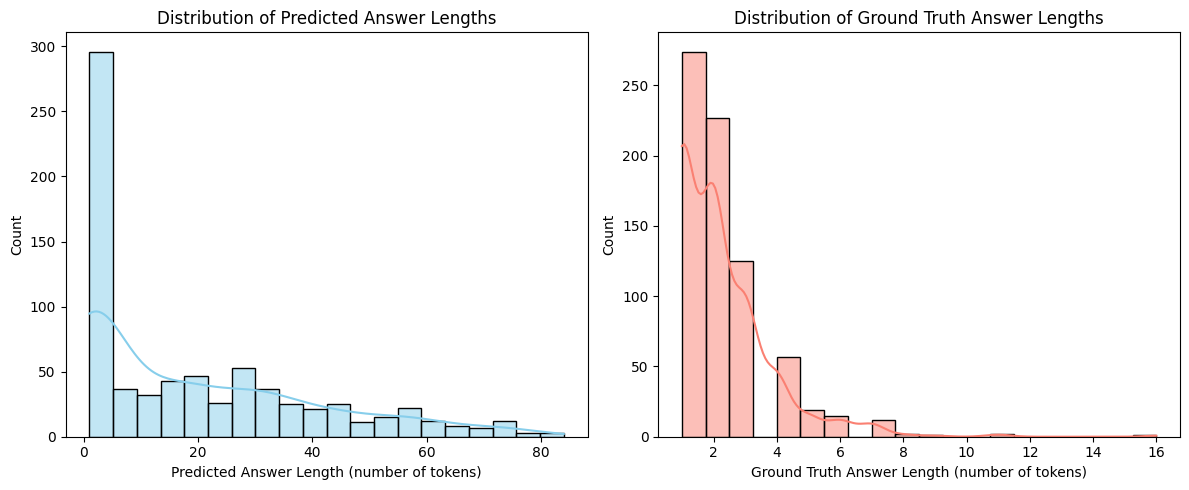

In [17]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df['pred_length'], bins=20, kde=True, color='skyblue')
plt.title("Distribution of Predicted Answer Lengths")
plt.xlabel("Predicted Answer Length (number of tokens)")

plt.subplot(1, 2, 2)
sns.histplot(df['gt_length'], bins=20, kde=True, color='salmon')
plt.title("Distribution of Ground Truth Answer Lengths")
plt.xlabel("Ground Truth Answer Length (number of tokens)")

plt.tight_layout()
plt.show()

### 4. Performance Variation (F1 score) with Question Type (Categories: what, who, when, how, which, where, why, other)

In [18]:
def extract_question_type(question):
    if not question or pd.isna(question):
        return 'other'
    
    # Get the first token from the question
    first_word = question.split()[0].lower()
    common = {'what', 'who', 'when', 'how', 'which', 'where', 'why'}

    if first_word in common:
        return first_word
    
    return 'other'

df['question_type'] = df['question'].apply(extract_question_type)

# Compute mean F1 score for each question type
f1_by_qtype = df.groupby('question_type')['f1'].agg(['mean', 'count']).reset_index()
print("\nF1 score by Question Type:")
print(f1_by_qtype)


F1 score by Question Type:
  question_type      mean  count
0           how  0.279266     86
1         other  0.137667    117
2          what  0.108052    301
3          when  0.183638     48
4         where  0.080550     38
5         which  0.133505     41
6           who  0.071965     98
7           why  0.272513      6


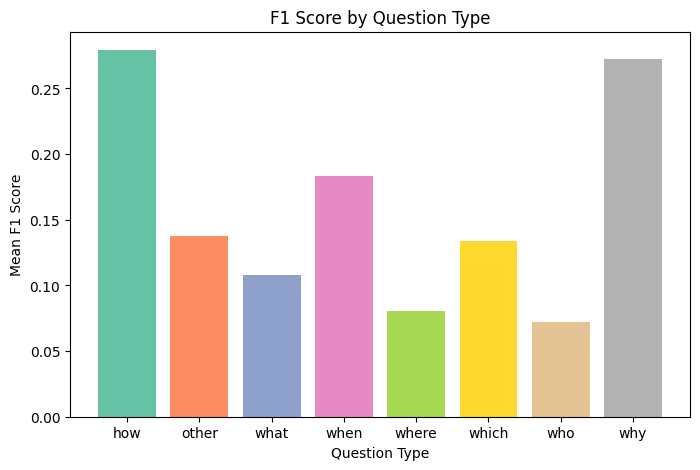

In [19]:
sorted_qtypes = sorted(f1_by_qtype['question_type'])
sorted_f1_qtype = f1_by_qtype.set_index('question_type').loc[sorted_qtypes].reset_index()
colors = cm.Set2(np.linspace(0, 1, len(sorted_f1_qtype)))

plt.figure(figsize=(8, 5))
bars = plt.bar(sorted_f1_qtype['question_type'], sorted_f1_qtype['mean'], color=colors)
plt.xlabel('Question Type')
plt.ylabel('Mean F1 Score')
plt.title('F1 Score by Question Type')
plt.show()

### 5. F1 score with respect to answer length bins (length 1, 2, 3, ..., >9)

In [20]:
# Compute mean F1 for each answer length bin
f1_by_length = df.groupby('length_bin')['f1'].agg(['mean', 'count']).reset_index()
print("F1 score by Answer Length:")
print(f1_by_length)

F1 score by Answer Length:
  length_bin      mean  count
0          1  0.137891    274
1          2  0.095371    227
2          3  0.150226    125
3          4  0.161158     57
4          5  0.168865     19
5          6  0.269558     15
6          7  0.231045     12
7          8  0.107692      2
8          9  0.177778      1
9         >9  0.290487      3


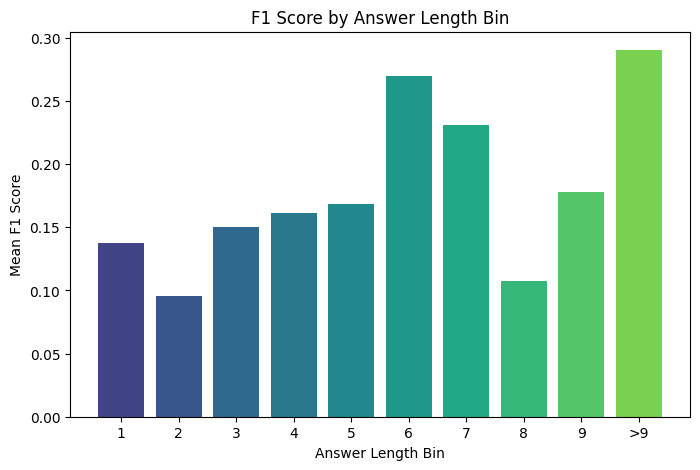

In [21]:
# Sort bins so that numerical values come in order (bins labeled with digits are sorted numerically)
sorted_bins = sorted(f1_by_length['length_bin'], key=lambda x: int(x) if x.isdigit() else 100)
sorted_f1_length = f1_by_length.set_index('length_bin').loc[sorted_bins].reset_index()
colors = cm.viridis(np.linspace(0.2, 0.8, len(sorted_f1_length)))

plt.figure(figsize=(8, 5))
bars = plt.bar(sorted_f1_length['length_bin'], sorted_f1_length['mean'], color=colors)
plt.xlabel('Answer Length Bin')
plt.ylabel('Mean F1 Score')
plt.title('F1 Score by Answer Length Bin')
plt.show()